In [1]:
from gurobipy import GRB
import gurobipy as gp
from typing import Optional
from collections import defaultdict
import heapq
import time
from collections import defaultdict
from uuid import uuid4
import copy
import random
import threading
from enum import Enum, auto
import logging
from benchmarks.benchmark_utils import RequestFuncOutput
import os
import collections
import numpy as np

logging = logging.getLogger(__name__)
DEBUG_COUNTER = 0
class LpNode:
    def __init__(self, node_id, num_gpus):
        self.node_id = node_id
        self.variables = [
            None for _ in range(num_gpus)
        ]  # Will be initialized as binary variables in the model
        self.children_token_cost_at_max_depth = 0  # Issue is that depth_limit will cut off the tokens for children and that will treat it as free
        self.randomly_selected_gpu = None
        self.load_variables = [None for _ in range(num_gpus)]
        self.common_load = None

    def __repr__(self):
        variable_values = [var.x if var else None for var in self.variables]
        load_variable_values = [var.x if var else None for var in self.load_variables]
        common_load = self.common_load.x if self.common_load else None
        # ignore printing laod variables if None
        if any(load_variable_values):
            return f"LpNode(node_id={self.node_id}, variables={variable_values}, load_variables={load_variable_values}, common_load={common_load})"
        else:
            return f"LpNode(node_id={self.node_id}, variables={variable_values})"


class LPTreeNode:
    def __init__(self):
        self.id = uuid4()
        self.children = defaultdict(LPTreeNode)
        self.parent: Optional[LPTreeNode] = None
        self.value = None
        self.ref_counter = 0
        self.last_access_time = time.time()
        self.gpu_selections = set()
        self.is_leaf = False
        self.decode_length = 0
        self.context_length = 0

    @property
    def num_tokens(self):
        return len(self.value)

    def __lt__(self, other):
        return self.last_access_time < other.last_access_time

    def __eq__(self, other):
        if isinstance(other, LPTreeNode):
            return self.id == other.id  # Compare nodes based on their unique ID
        return False

    def __hash__(self):
        return hash(self.id)  # Use the unique ID for hashing

    def __repr__(self) -> str:
        return f"LPTreeNode(id={self.id}, ref_counter={self.ref_counter}, gpu_selections={self.gpu_selections})"


def match(key, seq):
    i = 0
    for k, w in zip(key, seq):
        if k != w:
            break
        i += 1
    return i


class LPRadixCache:
    def __init__(self, disable=False):
        self.reset()
        self.disable = disable

    ##### Public API #####

    def reset(self):
        self.root_node = LPTreeNode()
        self.root_node.value = []
        self.root_node.ref_counter = 1
        self.evictable_size_ = 0

    def find_node(self, key):
        if self.disable:
            return None
        current_gpu_selection, node = self.match_prefix_get_gpu_selection(key)
        return node

    def match_prefix_get_gpu_selection(self, key, path_to_node=[]):
        if self.disable:
            return [], self.root_node

        value = []
        current_gpu_selection = self.root_node.gpu_selections
        current_gpu_selection, node = self._match_prefix_helper_gpu_selection(
            self.root_node, key, value, current_gpu_selection
        )
        return current_gpu_selection, node

    def _match_prefix_helper_gpu_selection(
        self, node, key, value, current_gpu_selection
    ):
        child: LPTreeNode
        for c_key, child in node.children.items():
            prefix_len = match(c_key, key)
            if prefix_len != 0:
                if child.gpu_selections:
                    current_gpu_selection = child.gpu_selections
                if prefix_len < len(c_key):
                    print(prefix_len, len(c_key))
                    assert False
                    new_node = self._split_node(
                        c_key, child, prefix_len, new_nodes_created=new_nodes_created
                    )
                    value.append(new_node.value)
                    # last_node[0] = new_node
                else:
                    value.append(child.value)
                    # last_node[0] = child
                    return self._match_prefix_helper_gpu_selection(
                        child, key[prefix_len:], value, current_gpu_selection
                    )
        return current_gpu_selection, node

    def match_prefix_return_str(self, key):
        return "".join(self.match_prefix(key)[0])

    def insert(
        self,
        key,
        value=None,
        node_map=None,
        all_modified_nodes=None,
        split_nodes=None,
        depth_limit=0,
    ):
        if node_map is None:
            node_map = {}
        if all_modified_nodes is None:
            all_modified_nodes = set()
        if split_nodes is None:
            split_nodes = {}  # key -> node
        if self.disable:
            return len(key)

        if value is None:
            value = [x for x in key]
        modified_nodes = set()
        created_node = self._insert_helper(
            self.root_node,
            key,
            value,
            node_map=node_map,
            modified_nodes=modified_nodes,
            depth_limit=depth_limit,
            current_depth=0,
            split_nodes=split_nodes,
        )

        node: LPTreeNode = created_node
        while node is not None:
            if node in all_modified_nodes:
                break
            all_modified_nodes.add(node)
            node = node.parent
        return created_node

    def pretty_print(self):
        self._print_helper(self.root_node, 0)
        print(f"#tokens: {self.total_size()}")

    def total_size(self):
        return self._total_size_helper(self.root_node)

    def evict(self, num_tokens, evict_callback):
        if self.disable:
            raise RuntimeError()

        leaves = self._collect_leaves()
        heapq.heapify(leaves)

        num_evicted = 0
        while num_evicted < num_tokens and len(leaves):
            x = heapq.heappop(leaves)

            if x == self.root_node:
                break
            if x.ref_counter > 0:
                continue

            num_evicted += evict_callback(x)
            self._delete_leaf(x)

            if len(x.parent.children) == 0:
                heapq.heappush(leaves, x.parent)

    def inc_ref_counter(self, node):
        delta = 0
        while node != self.root_node:
            if node.ref_counter == 0:
                self.evictable_size_ -= len(node.value)
                delta -= len(node.value)
            node.ref_counter += 1
            node = node.parent
        return delta

    def dec_ref_counter(self, node):
        delta = 0
        while node != self.root_node:
            # if node.ref_counter == 1: TODO why does this exist?
            #     self.evictable_size_ += len(node.value)
            #     delta += len(node.value)
            node.ref_counter -= 1
            node = node.parent
        return delta

    def remove_completed_input_ids(self, input_ids):
        node = self.find_node(input_ids)
        self.dec_ref_counter(node)  # remove reference counter up to parent
    
    def evictable_size(self):
        return self.evictable_size_

    def _split_node(
        self, key, child: LPTreeNode, split_len, node_map, depth_limit, current_depth
    ):
        # new_node -> child
        new_node = LPTreeNode()
        new_node.gpu_selections = copy.deepcopy(child.gpu_selections)
        new_node.children = {key[split_len:]: child}
        new_node.parent = child.parent
        new_node.ref_counter = child.ref_counter
        new_node.context_length = child.parent.context_length + split_len

        new_node.value = child.value[:split_len]
        child.parent = new_node
        child.value = child.value[split_len:]

        new_node.parent.children[key[:split_len]] = new_node
        del new_node.parent.children[key]
        return new_node

    def _insert_helper(
        self,
        node: LPTreeNode,
        key,
        value,
        node_map,
        modified_nodes,
        depth_limit,
        current_depth,
        split_nodes,
        parent_context_length = 0
    ):
        node.last_access_time = time.time()
        node.ref_counter += 1

        for c_key, child in node.children.items():
            prefix_len = match(c_key, key)
            if prefix_len == len(c_key):
                if prefix_len == len(key):
                    child.ref_counter += 1
                    modified_nodes.add(child)
                    return child
                else:
                    key = key[prefix_len:]
                    value = value[prefix_len:]
                    return self._insert_helper(
                        child,
                        key,
                        value,
                        node_map=node_map,
                        modified_nodes=modified_nodes,
                        depth_limit=depth_limit,
                        current_depth=current_depth + 1,
                        split_nodes=split_nodes,
                        parent_context_length=parent_context_length + prefix_len,
                    )

            if prefix_len:
                new_node = self._split_node(
                    c_key,
                    child,
                    prefix_len,
                    node_map,
                    depth_limit=depth_limit,
                    current_depth=current_depth + 1,
                )
                # modified_nodes.add(new_node)
                # modified_nodes.add(child)
                # TODO check if this makes sense to ignore this?
                # if child in node_map and current_depth < depth_limit:
                split_nodes[child] = new_node
                return self._insert_helper(
                    new_node,
                    key[prefix_len:],
                    value[prefix_len:],
                    node_map=node_map,
                    modified_nodes=modified_nodes,
                    depth_limit=depth_limit,
                    current_depth=current_depth + 1,
                    split_nodes=split_nodes,
                    parent_context_length=parent_context_length + prefix_len,
                )

        if len(key):
            new_node = LPTreeNode()
            new_node.gpu_selections = set()
            new_node.parent = node
            new_node.value = value
            new_node.ref_counter = 1
            new_node.context_length = parent_context_length + len(key)

            node.children[key] = new_node
            self.evictable_size_ += len(value)
            # if current_depth < depth_limit:
            modified_nodes.add(new_node)
            # return new_node
            return new_node
        return node

    def _print_helper(self, node, indent, depth=0):
        if depth == 5:
            return
        for key, child in node.children.items():
            print(" " * indent, child)
            self._print_helper(child, indent=indent + 2, depth=depth + 1)

    def _delete_leaf(self, node):
        for k, v in node.parent.children.items():
            if v == node:
                break
        del node.parent.children[k]
        self.evictable_size_ -= len(k)

    def _total_size_helper(self, node):
        x = len(node.value)
        for child in node.children.values():
            x += self._total_size_helper(child)
        return x

    def _collect_leaves(self):
        ret_list = []

        def dfs_(cur_node):
            if len(cur_node.children) == 0:
                ret_list.append(cur_node)

            for x in cur_node.children.values():
                dfs_(x)

        dfs_(self.root_node)
        return ret_list

from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-v0.1")

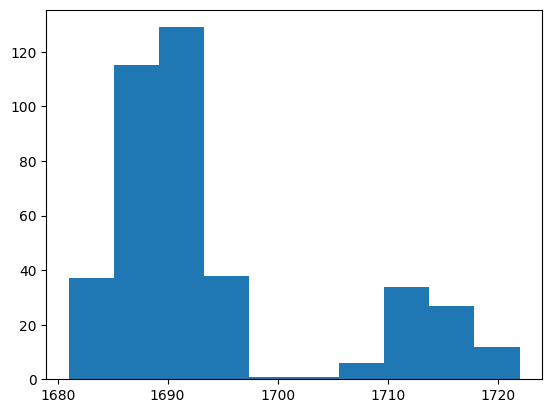

In [2]:
from benchmarks.benchmark_workload_gen import WorkloadPrefixDataLoader, ToolBenchDataLoader, LooGLEDataset, LoadDistribution

random_workload = WorkloadPrefixDataLoader(
        num_patterns=200,
        total_num_requests=400,
        tokenizer=tokenizer,
        load_dist = LoadDistribution.EVEN,
        distribution_of_non_shared = 0.2,
        output_len=16,
        num_in_context_examples = 3,
        random_workload_path="benchmarks/datasets/ShareGPT_V3_unfiltered_cleaned_split.json"
)
requests = random_workload.generate_workload(k=None)

In [3]:
toolbench_workload = ToolBenchDataLoader(
    num_patterns=200,
    total_num_requests=400,
    tokenizer=tokenizer,
    load_dist = LoadDistribution.EVEN,
    data_path="benchmarks/datasets/G1_workload_updated_input_output_lengths_4096.json",
)
toolbench_requets = toolbench_workload.generate_workload(k=None)

In [7]:
from collections import defaultdict
mem_cost = [0, 0]
num_gpus = 2
gpu_allocations = defaultdict(set)

def get_recomp_cost(node: LPTreeNode, gpu_id):
    if not node or gpu_id in gpu_allocations[node]:
        return 0
    else:
        return node.num_tokens + get_recomp_cost(node.parent, gpu_id)

def update_gpu_selections_of_parent(node: LPTreeNode, gpu_id):
    if not node:
        return
    node.gpu_selections.add(gpu_id)
    update_gpu_selections_of_parent(node.parent, gpu_id)
def handle_split_nodes(split_nodes, gpu_allocations):
    for k, v in split_nodes.items():
        gpu_allocations[k] = gpu_allocations[v].copy()

cache = LPRadixCache()
for request in requests[:64]:
    split_nodes = {}
    leaf_node = cache.insert(tuple(request["input_ids"]), split_nodes=split_nodes)
    handle_split_nodes(split_nodes, gpu_allocations)
    recom_costs = []
    for gpu_id in range(num_gpus):
        recomputation_cost = get_recomp_cost(leaf_node, gpu_id)
        recom_costs.append(recomputation_cost)
    gpu_selected = np.argmin([recom_costs[gpu_id] + mem_cost[gpu_id] for gpu_id in range(num_gpus)])
    mem_cost[gpu_selected] += recom_costs[gpu_selected]
    update_gpu_selections_of_parent(leaf_node, gpu_selected)

In [56]:
reqs = []
for req in toolbench_requets:
    reqs.append(req["input_ids"])

In [12]:
def _print_helper(node, indent, depth=0):
    for key, child in node.children.items():
        print(" " * indent, tokenizer.decode(child.value)[:20], child.gpu_selections, len(child.value))
        _print_helper(child, indent=indent + 2, depth=depth + 1)
_print_helper(cache.root_node, 0)

 <s> System: You are  {0, 1} 358
   icehockeyapi: IceHoc {0} 2216
   fluximmo: API de flu {1} 2661
   kenyan_news_api: Non {0} 809
   valorant_weapons: Pr {0} 752
   zodiacapi: Simple Zo {1} 622
   instagram_api_2023:  {0} 2585
   trackmania: Get Stat {1} 2189
   complete_study_bible {1} 2505
   world_population_by_ {1} 1346
   temp_email: The Temp {1} 570
   dcps_project: Gets a {1} 666
   reqres: Reqres

Spec {1} 456
   opensea_v2: Opensea  {0} 2109
   evosis_s_game_databa {1} 968
   get_58_provinces_of_ {0} 510
   spotify_web: Spotify {1} 1651
     need to compile a li {1} 474
     want to explore the  {1} 668
   dimondevosint: It is {0} 1146
   financial_statements {0} 1668
   horoscopes_ai: Horos {0} 1275
   api_video: api.video {0} 2493
   tiktok_user: Get pro {1} 514
   auth: OAuth2 Authori {0} 953
     'm building an appli {0} 526
     need to retrieve the {0} 270
   oil_thai_price: Pric {1} 1220
   rushtranslate: Human {1} 1588
   iys_skill_api: With  {0} 1894
   lorem_ipsum_a

In [10]:
from collections import defaultdict
mem_cost = [0, 0]
num_gpus = 2
gpu_allocations = defaultdict(set)

def get_recomp_cost(node: LPTreeNode, gpu_id):
    if not node or gpu_id in gpu_allocations[node]:
        return 0
    else:
        return node.num_tokens + get_recomp_cost(node.parent, gpu_id)

def update_gpu_selections_of_parent(node: LPTreeNode, gpu_id):
    if not node:
        return
    node.gpu_selections = node.gpu_selections.union(gpu_id)
    update_gpu_selections_of_parent(node.parent, gpu_id)
def handle_split_nodes(split_nodes, gpu_allocations):
    for k, v in split_nodes.items():
        gpu_allocations[k] = gpu_allocations[v].copy()

def get_parent_gpu_selections(node: LPTreeNode):
    if not node:
        return set()
    if node.gpu_selections:
        return node.gpu_selections
    return get_parent_gpu_selections(node.parent)

cache = LPRadixCache()
for request in toolbench_requets[:64]:
    split_nodes = {}
    leaf_node = cache.insert(tuple(request["input_ids"]), split_nodes=split_nodes)
    handle_split_nodes(split_nodes, gpu_allocations)
    print(leaf_node.num_tokens, leaf_node.context_length)
    
    gpu_selected:set
    if leaf_node.num_tokens < leaf_node.context_length - leaf_node.num_tokens:
        gpu_selected = get_parent_gpu_selections(leaf_node)
        for gpu in gpu_selected:
            mem_cost[gpu] += get_recomp_cost(leaf_node, gpu)
    else:
        recom_costs = []
        for gpu_id in range(num_gpus):
            recomputation_cost = get_recomp_cost(leaf_node, gpu_id)
            recom_costs.append(recomputation_cost)
        gpu_selected = np.argmin([recom_costs[gpu_id] + mem_cost[gpu_id] for gpu_id in range(num_gpus)])
        mem_cost[gpu_selected] += recom_costs[gpu_selected]
        gpu_selected = set([gpu_selected])
    update_gpu_selections_of_parent(leaf_node, gpu_selected)

2574 2574
984 1342
2661 3019
880 1238
809 1167
660 1018
752 1110
622 980
2585 2943
2189 2547
2505 2863
1445 1803
1479 1837
1346 1704
2433 2791
570 928
666 1024
456 814
1497 1855
2125 2483
2109 2467
968 1326
510 868
668 2677
1146 1504
1668 2026
3410 3768
1275 1633
2493 2851
514 872
270 1581
1220 1578
1588 1946
1894 2252
844 1202
580 938
987 1345
1057 1415
1049 1407
2418 2776
1042 1401
718 1076
2588 2948
3403 3761
1940 2298
1346 1704
64 1045
1825 2183
879 1237
1580 1938
771 1129
622 980
452 810
1179 1539
3151 3509
3095 3454
1016 1374
1419 1777
72 1356
2091 2449
1499 1860
441 1251
708 1066
1802 2160


In [13]:
from benchmarks.benchmark_workload_gen import LooGLEDataset, LooGLEDatasetType
dataloader = LooGLEDataset(
    num_patterns=24,
    total_num_requests=250,
    tokenizer=tokenizer,
    loogle_dataset_type=LooGLEDatasetType.SHORT_QA
)
requests = dataloader.generate_workload(max_length=32768)

/mnt/data/ssd/sglang_env/lib/python3.9/site-packages/datasets/load.py:1461: FutureWarning: The repository for bigainlco/LooGLE contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/bigainlco/LooGLE
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [11]:
from collections import defaultdict
mem_cost = [0, 0]
num_gpus = 2
gpu_allocations = defaultdict(set)

def get_recomp_cost(node: LPTreeNode, gpu_id):
    if not node or gpu_id in gpu_allocations[node]:
        return 0
    else:
        return node.num_tokens + get_recomp_cost(node.parent, gpu_id)

def update_gpu_selections_of_parent(node: LPTreeNode, gpu_id):
    if not node:
        return
    node.gpu_selections = node.gpu_selections.union(gpu_id)
    update_gpu_selections_of_parent(node.parent, gpu_id)
def handle_split_nodes(split_nodes, gpu_allocations):
    for k, v in split_nodes.items():
        gpu_allocations[k] = gpu_allocations[v].copy()

def get_parent_gpu_selections(node: LPTreeNode):
    if not node:
        return set()
    if node.gpu_selections:
        return node.gpu_selections
    return get_parent_gpu_selections(node.parent)

cache = LPRadixCache()
for request in toolbench_requets[:64]:
    split_nodes = {}
    leaf_node = cache.insert(tuple(request["input_ids"]), split_nodes=split_nodes)
    handle_split_nodes(split_nodes, gpu_allocations)
    print(leaf_node.num_tokens, leaf_node.context_length)
    
    gpu_selected:set
    if leaf_node.num_tokens < leaf_node.context_length - leaf_node.num_tokens:
        gpu_selected = get_parent_gpu_selections(leaf_node)
        for gpu in gpu_selected:
            mem_cost[gpu] += get_recomp_cost(leaf_node, gpu)
    else:
        recom_costs = []
        for gpu_id in range(num_gpus):
            recomputation_cost = get_recomp_cost(leaf_node, gpu_id)
            recom_costs.append(recomputation_cost)
        gpu_selected = np.argmin([recom_costs[gpu_id] + mem_cost[gpu_id] for gpu_id in range(num_gpus)])
        mem_cost[gpu_selected] += recom_costs[gpu_selected]
        gpu_selected = set([gpu_selected])
    update_gpu_selections_of_parent(leaf_node, gpu_selected)
_print_helper(cache.root_node, 0)

 <s> System: You are  {0, 1} 358
   icehockeyapi: IceHoc {0} 2216
   fluximmo: API de flu {1} 2661
   kenyan_news_api: Non {0} 809
   valorant_weapons: Pr {0} 752
   zodiacapi: Simple Zo {1} 622
   instagram_api_2023:  {0} 2585
   trackmania: Get Stat {1} 2189
   complete_study_bible {1} 2505
   world_population_by_ {1} 1346
   temp_email: The Temp {1} 570
   dcps_project: Gets a {1} 666
   reqres: Reqres

Spec {1} 456
   opensea_v2: Opensea  {0} 2109
   evosis_s_game_databa {1} 968
   get_58_provinces_of_ {0} 510
   spotify_web: Spotify {1} 1651
     need to compile a li {1} 474
     want to explore the  {1} 668
   dimondevosint: It is {0} 1146
   financial_statements {0} 1668
   horoscopes_ai: Horos {0} 1275
   api_video: api.video {0} 2493
   tiktok_user: Get pro {1} 514
   auth: OAuth2 Authori {0} 953
     'm building an appli {0} 526
     need to retrieve the {0} 270
   oil_thai_price: Pric {1} 1220
   rushtranslate: Human {1} 1588
   iys_skill_api: With  {0} 1894
   lorem_ipsum_a